# Speaker-Independent Spoken Digit Recognition (xSDR)


One of the successful stories of deep neural networks is the proliferation of commercial of automatic speech recognition (ASR) systems. This project aims to explore one application of ML-powered ASR to the problem of spoken digit recognition (SDR). Since digits are widely used as unique identifiers for bank information, social security numbers, post codes, etc, SDR systems can be an efficient alternative to fully-fledged ASR systems since the domain is more predictable than other applications of ASR. 

In this project, we focus on developing a SDR system in a speaker-independent setting. That is, the speakers in the evaluation set are disjoint from the training set speakers. We do so because we expect real-world ASR systems to generalize to different speakers than those we have data for. Moreover, for many languages that are under-resourced, we have have (limited) annotated speech data from a single speaker, but we would still want the system to be deployed to work on any speaker of that language. We tackle the problem of spoken digit recognition as a sequence classification task. Concretely, the inputs are short audio clips of a specific digit (in the range 0-9), then the goal is to build deep neural network models to classify a short audio clip and predict the digit that was spoken.

# Notes

## Code Submission

You don't necessarily need to complete the code in this Jupyter Notebook, you are free to use another notebook or a python script file, as you would like. You are expected to submit the code by **22.03.2023**.

Your code should be clean and well commented. We also expect that if we decide to run it on our system, it should be straighforward to do so. We recommend creating a ```requirements.txt``` file with the names of all the libraries with their versions. If applicable, please mention the python version in a ```README.md``` file, which should also include instructions on how to run your code.

As mentioned for the assignments, always remember to cite the code with the links as comments, if you decide to use it from a public repository.

## Report Submission

With the code, you are also expected to submit a report with a maximum of 4 pages. You should write your report in LaTeX using this template for ACL 2023 [Overleaf Link](https://www.overleaf.com/latex/templates/acl-2023-proceedings-template/qjdgcrdwcnwp). Use this document to fill in any missing information that are not necessarily covered during your presentation for the sake of time in the presentation. While writing your report, we would highly encourgae you to cite the papers behind each tool / library / function that you might use for your experiments. We have also released an example on how to write equations in LaTeX [here](https://piazza.com/class/l9so16qqvk34hu/post/52).

You art also expected to submit this report with your code. You should provide the **.tex, .pdf and all image files** zipped with the same naming convention as it was in your assignment(s).

## Presentation

During the last week of March 2023, i.e. 27.03 -- 31.03, each team will be presenting their works for 15 minutes. We expect equal contribution from each member in delivery and content of the presentation. So roughly 5 minutes for one person, if you have 3 people in your team. There will be 5 minutes for some Q&A. At-least one person from your team should be present to do an in-person presentation, rest of your team could join remotely, if they are not present.

## Important Dates

 - Code & Report Submission: 22.03.2023 (08.00)
 - Presentation: 27.03.2023 -- 31.03.2023
 
 You'll get a precise date and time for your team's presentation at a later time.

### Grading

In this project, your final grades will be determined as follows:

 - **30%**: &emsp; Completing all the tasks
 - **30%**: &emsp; Providing scientific-backings for all the methods used
 - **20%**: &emsp; Quality of the content of the presentation
 - **20%**: &emsp; Delivery of the presentation

In [1]:
#%matplotlib inline
import numpy as np
import scipy, matplotlib.pyplot as plt, IPython.display as ipd
import librosa, librosa.display

import pandas as pd

from sklearn  import preprocessing


from collections import defaultdict, Counter

# add this to ignore warnings from Librosa
import warnings
warnings.filterwarnings('ignore')

import random

In [2]:
# for linear models 
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

In [3]:
from sklearn.neural_network import MLPClassifier

## Exploring the Dataset 

The speech samples are already divied into training, development, and test spilts. The splits are made in such way that evaluation speakers are not present in training split. You should use the splits as they are. 

**CAUTION:** 

In this project, you are not allowed to use any external data for this problem (at least for the main three tasks). Exploring the effect of additional datasets in this project can only included as a further step after completing the main requirements with the given data. 

In [4]:
# read tsv file into a dataframe 
sdr_df = pd.read_csv('SDR_metadata.tsv', sep='\t', header=0, index_col='Unnamed: 0')

In [5]:
sdr_df.head()

,identifier,speaker,split,label,file
0,5_theo_23,theo,TRAIN,5,speech_data/5_theo_23.wav
1,2_yweweler_39,yweweler,TEST,2,speech_data/2_yweweler_39.wav
2,6_yweweler_34,yweweler,DEV,6,speech_data/6_yweweler_34.wav
3,6_yweweler_16,yweweler,DEV,6,speech_data/6_yweweler_16.wav
4,9_yweweler_2,yweweler,TEST,9,speech_data/9_yweweler_2.wav


In [6]:
set(sdr_df.speaker.values)

{'george', 'jackson', 'lucas', 'nicolas', 'theo', 'yweweler'}

In [26]:
# explore one sample: 7_theo_0
sdr_df.loc[sdr_df['identifier'] == '7_theo_0']

,identifier,speaker,split,label,file
700,7_theo_0,theo,TRAIN,7,speech_data/7_theo_0.wav


In [43]:
spectogram_data = []
for i in sdr_df.loc[sdr_df['split'] == 'TRAIN'].file:
    x, sr = librosa.load(i, sr=SAMPLING_RATE)
    spectogram_data.append(extract_melspectrogram(x, sr, num_mels=13))
mini, maxi = 100, 1 
for i in spectogram_data:
    #print(i.shape)
    mini = min(mini, i.shape[1])
    maxi = max(maxi, i.shape[1])
print(mini, maxi)

15 229


In [9]:
sample_wav_file = sdr_df.loc[sdr_df['identifier'] == '7_theo_0'].file[700]

## The Speech Waveform

The acoustic realization of speech segment can be (digitally) viewed as a time-variant wavform $\mathbf{S} \in \mathbb{R}^{n}$. Here, $n$ depends on both the duration of the speech segment and the sampling rate of the continous speech singal. Let's check out one sample from the data set. 

In [28]:
# play and listen to a sample 
SAMPLING_RATE = 8000 # This value is determined by the wav file, DO NOT CHANGE

x, sr = librosa.load(sample_wav_file, sr=SAMPLING_RATE) #, 
ipd.Audio(x, rate=sr)

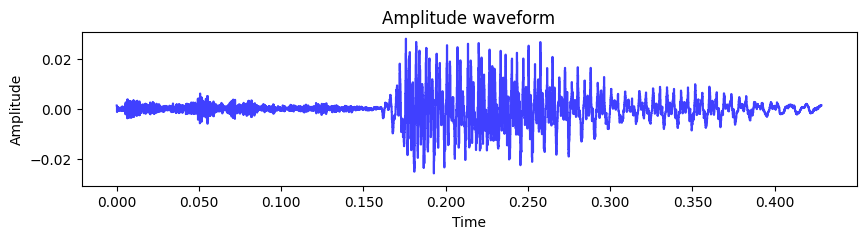

In [11]:
# plot as a waveform 
fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.waveshow(y=x, sr=sr, alpha=0.75, x_axis='time', color='blue')

ax.set(title='Amplitude waveform')
ax.set_ylabel('Amplitude')
ax.label_outer()

In [12]:
# sample duration in milliseconds
(1000*len(x))/SAMPLING_RATE

428.5

In the cell above, you can see the temporal duration of the audio is 428.5 milliseconds. For digits in the range 0-9, the duration of the speech segment should be around 0.5 seconds with reasonable variation depending on speech rate (i.e., how fast the speaker speaks). 

## The Speech Signal Representation - Mel Spectrograms

Humans can recognize and differentiate different speech sounds based on the frequency characteristics of the sounds. For machine learning applications, human speech is represented using spectro-temporal features in the [Mel-scale](https://en.wikipedia.org/wiki/Mel_scale) extracted from the speech sample. Mel-scale features are inspired by human speech perception and auditory processing whereby the human ear has difference sensitivity (or resolution) in differet frequency bandes. That is, the human ear can better recognize differences in in lower range frequences, while higher range frequences have a lower resolution. The Mel-scale is linear for frequencies in the range (0-1kHz), and logarithmic for frequencies above 1kHz.

In the spectro-temporal representation of speech, a speech sample can be seen as a sequence of $T$ spectral vectors as $\mathbf{X} = (\mathbf{x}^1, \mathbf{x}^2, \dots, \mathbf{x}^T)$. Each spectral vector $\mathbf{x}^t \in \mathbb{R}^{k}$ at time-step $t$ is extracted from a short speech segment (~25 milliseconds) with the assumption that the signal is time-invariant in this small time window. Here, $k$ is the number of frequency bands in the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) and this is a parameter of the feature extraction pipeline. The representation is based on the Fourier transform to convert the temporal signal into the frequency domain. 

In automatic speech recognition (ASR) research and applications, spectral vectors are usually referred to as "acoustic frames". Morover, adjacent frames are extracted with some overlap between them, usually ~10 milliseconds. 

In [53]:
def extract_melspectrogram(signal, sr, num_mels):
    """
    Given a time series speech signal (.wav), sampling rate (sr), 
    and the number of mel coefficients, return a mel-scaled 
    representation of the signal as numpy array.
    """
    
    mel_features = librosa.feature.melspectrogram(y=signal,
        sr=sr,
        n_fft=200, # with sampling rate = 8000, this corresponds to 25 ms
        hop_length=80, # with sampling rate = 8000, this corresponds to 10 ms
        n_mels=num_mels, # number of frequency bins, use either 13 or 39
        fmin=50, # min frequency threshold
        fmax=4000 # max frequency threshold, set to SAMPLING_RATE/2
    )
    
    # for numerical stability added this line
    mel_features = np.where(mel_features == 0, np.finfo(float).eps, mel_features)

    # 20 * log10 to convert to log scale
    log_mel_features = 20*np.log10(mel_features)

    # feature scaling
    scaled_log_mel_features = preprocessing.scale(log_mel_features, axis=1)
    
    return scaled_log_mel_features

In [54]:
melspectrogram = extract_melspectrogram(x, sr, num_mels=13)

In [87]:
N = 15
k, T = melspectrogram.shape
split_size = T // N
remaining_size = T % N
splitted_X = []
for i in range(N):
    if remaining_size:
        remaining_size -= 1
        splitted_X.append(melspectrogram[:, i*split_size:(i+1)*split_size+1])
        continue
    splitted_X.append(melspectrogram[:, i*split_size:(i+1)*split_size])
mean_arr = []
for split in splitted_X:
    mean_arr.append(np.mean(split, axis=1)) 
new_arr = np.column_stack(mean_arr)
final = np.reshape(new_arr, (N*k,))

51 3 13
6


(195,)

In [74]:
melspectrogram

array([[-2.97021198e+00, -1.82726622e+00, -1.26787043e+00,
        -7.43739456e-02,  6.46929562e-01,  6.80351377e-01,
         8.83502901e-01,  9.01455522e-01,  6.55475080e-01,
         6.54103100e-01,  7.55525708e-01,  6.81510985e-01,
         7.43224978e-01,  8.16262007e-01,  5.84836066e-01,
         4.49537009e-01,  5.07379234e-01,  4.49840993e-01,
         5.11854172e-01,  5.49657822e-01,  7.40666807e-01,
         9.26913679e-01,  9.83042359e-01,  1.04044807e+00,
         1.18668902e+00,  1.28012919e+00,  1.27757943e+00,
         1.20623577e+00,  1.09796381e+00,  8.17502081e-01,
         2.37611681e-01,  9.75962132e-02,  1.42554954e-01,
         2.92923227e-02, -7.16918558e-02, -2.43651077e-01,
        -7.36365676e-01, -6.27402604e-01, -3.70261580e-01,
        -2.75564909e-01, -3.00601959e-01, -5.90850711e-01,
        -1.22336495e+00, -1.49964201e+00, -1.60459232e+00,
        -1.23273289e+00, -1.21953154e+00, -1.13484657e+00,
        -1.28330112e+00, -1.20754361e+00, -1.77400422e+0

Note that the shape of the array (K x T) represents the number of frequency bands (K) and the number of spectral vectors in this representation (here, K=13, T=43). K is a hyperparameter and the recommended values in ASR research are (13, 39, 81, etc). Here, we fix K = 13. On the other hand, T varies from sample to sample depending on the duration of the sample.  

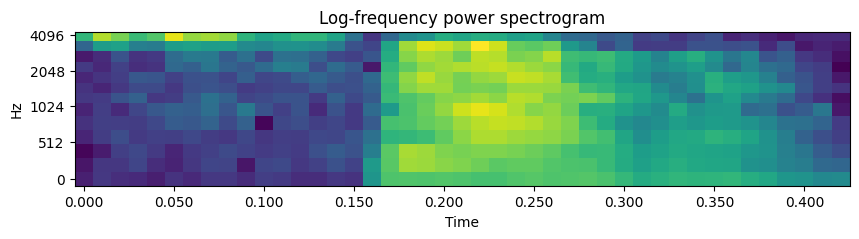

In [15]:
# plot and view the spectrogram

fig, ax = plt.subplots(figsize=(10, 2), sharex=True)

img = librosa.display.specshow(
    melspectrogram, 
    sr=sr, 
    x_axis='time', 
    y_axis='mel', 
    cmap='viridis', 
    fmax=4000, 
    hop_length=80
)

ax.set(title='Log-frequency power spectrogram')

ax.label_outer()

As you can see above from the figure, the spectrogram representation can be viewed as a matrix $\mathbf{X} \in \mathbb{R}^{T} \times \mathbb{R}^{k}$.  

## Task I
1. One problem with the spectrogram as a speech feature represetation is that different speech samples would have dfferent durations due to inherent speech variability (e.g., speech rate, speaker dialect, etc). That is, the $T$ in the $(T \times k)$-dimensional representation would be different for each sample. Therefore, for the baseline model, we will implement a method to have a fixed-size representation for all speech samples. Write a function downsample_spectrogram(X, N) that takes as input a spectrogram $\mathbf{X} \in \mathbb{R}^{T \times k}$ and a parameter N <= 25. The function should (1) make N equally-sized splits of S across the time-axis, (2) apply a pooling technique (e.g., mean pooling) to each split across the frequency axis to obtain an array that represents a downsampled version of the spectrogram $\mathbf{X}' \in \mathbb{R}^{N \times k}$, and (3) re-arange $\mathbf{X}'$ as a vector $\mathbf{v} \in \mathbb{R}^{Nk}$.    

2. Using the downsample_spectrogram(X, N) function, transform all the speech samples into vectors $\mathbf{v} \in \mathbb{R}^{Nk}$. 

3. Given the speaker-based train/dev/test spilts in the SDR_metadata.tsv, fit a linear model on the training samples. That is, your model should be build on data from 4 speakers {'nicolas', 'theo' , 'jackson',  'george'}. Hint: you can experiment with a few model alternatives in the SGDClassifier module in scikit-learn. 

4. Evaluate you model on the dev and test splits. Use accuracy as an evaluation metric. Analyze the model performance using a [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix) of the all possible labels (0-9), Analyze [precision, recall](https://en.wikipedia.org/wiki/Precision_and_recall), [F1-score](https://en.wikipedia.org/wiki/F-score) for each label. Report your observation.

In [88]:
def downsample_spectrogram(spectrogram, n=15):
    """
    Given a spectrogram of an arbitrary length/duration (X ∈ K x T),
    return a downsampled version of the spectrogram v ∈ K * N
    """
    if not n:
        return spectrogram
    k, t = spectrogram.shape
    each_split_size, remaining_size = divmod(t, n)
    splitted = [spectrogram[:, i * each_split_size:(i + 1) * each_split_size + (i < remaining_size)]
                for i in range(n)]
    splitted_mean_arr = [np.mean(split, axis=1) for split in splitted]
    return np.reshape(np.column_stack(splitted_mean_arr), (n * k,))

In [89]:
downsample_spectrogram(melspectrogram, 15)

array([-1.5349306 ,  0.5341025 ,  0.77363414,  0.7085912 ,  0.64846504,
        0.47965285,  0.6007263 ,  0.98346806,  1.2481326 ,  1.0405673 ,
        0.15925427, -0.09535021, -0.57800996, -0.38900587, -1.4425331 ,
       -1.5899994 , -0.169277  ,  1.0060797 ,  1.2225453 ,  0.7848202 ,
        0.46125776,  0.6467042 ,  1.0253831 ,  1.129516  ,  0.9810336 ,
        0.04874695, -0.09812971, -0.6522172 , -0.42654097, -1.5228201 ,
       -0.6386852 ,  0.22654553,  1.4556873 ,  1.5505935 ,  0.9400901 ,
        0.5993153 ,  0.80431086,  1.0330402 ,  0.6344368 ,  0.0827541 ,
       -0.4049809 , -0.59859616, -1.0323435 , -1.2585344 , -1.5939933 ,
       -0.13421464,  0.747108  ,  1.8454045 ,  1.616986  ,  0.75343335,
        0.6117769 ,  1.0115373 ,  0.2823163 ,  0.13946708, -0.08519166,
       -0.62910026, -1.0079592 , -1.301134  , -1.2453905 , -1.4100231 ,
       -0.37138247,  0.31592822,  1.7788653 ,  1.7262475 ,  0.49129042,
        0.5134746 ,  0.92996675,  0.82542676,  0.20629   , -0.37

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [ ]:
rom sklearn.linear_model import SGDClassifier

alphas = [0.0001, 0.001, 0.01, 0.1]

for alpha in alphas:
    clf = SGDClassifier(loss='log', penalty='l2', alpha=alpha, max_iter=1000, tol=1e-3)
    clf.fit(X_train_scaled, y_train)
    score = clf.score(X_test_scaled, y_test)
    print(f'alpha={alpha:.4f}, test score={score:.4f}')

## Baseline Model

In [ ]:
# prepare data and split 

# train a linear model 

# evaluate the model using accuracy metric

# analyze the confusion matrix of the baseline 

# report precision, recall, F1-score for each label 

In [ ]:
# X_train is a matrix of training spectrograms, each row representing one spectrogram
# y_train is a vector of training labels
# X_test is a matrix of test spectrograms, each row representing one spectrogram
# y_test is a vector of test labels

# Create an instance of the SGDClassifier with default parameters
clf = SGDClassifier()

# Train the classifier on the training set
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Compute the accuracy of the classifier on the test set
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

cm = confusion_matrix(y_true, y_pred)
print("Confusion matrix:\n", cm)

plot_confusion_matrix(clf, X_test, y_test)
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred)
print("Classification report:\n", report)

## Task II
1. Having established a baseline with a linear model trained on a downsampled signal representation of the speech segment, this task aims to learn a classifier based on the full speech segment. To this end, you will implement a neural model that is suitable for sequential data such as recurrent DNN, convolutional DNN with 1-D temporal convolution, or an audio transformer. The model should take the acoustic sample as it is (i.e., the Mel spectrogram could have an arbitrary length) without the need to downsample the segment. You need to implement at least two of the aforementioned models. Do the neural models improve accuracy over the baseline model? Do you observe any signs of overfitting to the training data? How do the hyperparameters affect the model performance? Report and discuss your observations.        

2. Evaluate your (best) neural models and compare to the baseline model using the same evalution process as in task I.4. 

3. Use a dimensionality reduction algorithm such as t-SNE \[[1](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding),[2](https://pypi.org/project/tsne-torch/),[3](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)\] or [UMAP](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) to analyze how the different models seperate the different classes (the last non-linear layer in your model). Compare to the downsampled representation you used in the baseline and report your observations.

4. Are the differences between the different models statistically significant? To answer this question, you need to implement a statistical significance test based on bootstrapping method. To read more how to estiame p-values based on bootstrapping, we recommend the materials on this paper https://aclanthology.org/D12-1091.pdf. Include the baseline model in your evaluation. 

In [ ]:
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    # Input layer
    keras.layers.Input(shape=(None, N_MELS)),
    
    # RNN layer
    keras.layers.LSTM(units=64, return_sequences=True),
    
    # Dense layer
    keras.layers.Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

In [ ]:
from tensorflow import keras

# Define the model architecture
model = keras.Sequential([
    # Input layer
    keras.layers.Input(shape=(None, N_MELS)),
    
    # Convolutional layers
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    
    # Global average pooling layer
    keras.layers.GlobalAveragePooling1D(),
    
    # Dense layer
    keras.layers.Dense(units=num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)


In [ ]:
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout
from tensorflow.keras.layers.experimental.preprocessing import Resizing, Normalization
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras import backend as K

# Define the model architecture
def transformer_model(n_classes, input_shape, d_model=256, n_heads=4, ff_dim=1024, dropout_rate=0.2):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Resize the input to a fixed shape
    resize_layer = Resizing(input_shape[0], d_model)(inputs)
    
    # Normalize the input
    normalize_layer = Normalization()(resize_layer)
    
    # Add positional encoding
    pos_encoding_layer = preprocessing.PositionalEncoding()(normalize_layer)
    
    # Add dropout
    dropout_layer = Dropout(dropout_rate)(pos_encoding_layer)
    
    # Transformer layers
    for i in range(4):
        # Multi-head attention
        attn_layer = keras.layers.MultiHeadAttention(num_heads=n_heads, key_dim=d_model // n_heads)(dropout_layer, dropout_layer)
        attn_layer = keras.layers.Dropout(dropout_rate)(attn_layer)
        attn_layer = keras.layers.LayerNormalization(epsilon=1e-6)(dropout_layer + attn_layer)
        
        # Feed-forward layer
        ff_layer = keras.layers.Dense(ff_dim, activation='relu')(attn_layer)
        ff_layer = keras.layers.Dense(d_model)(ff_layer)
        ff_layer = keras.layers.Dropout(dropout_rate)(ff_layer)
        ff_layer = keras.layers.LayerNormalization(epsilon=1e-6)(attn_layer + ff_layer)
        
        # Set the output of the final transformer layer as the input to the classification layer
        dropout_layer = ff_layer
        
    # Classification layer
    outputs = Dense(n_classes, activation='softmax')(dropout_layer)
    
    # Build the model
    model = keras.Model(inputs=inputs, outputs=outputs)
    
    return model

# Create the model
model = transformer_model(n_classes=num_classes, input_shape=(None, N_MELS))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val))

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

## Task III (Open Ended)
1. Consider the case where we have speech data from a single speaker (e.g., george). Train your models on this subset of the data. What do you observe? How does this affect the model performance? 

2. Even though a model is trained on a single speaker, we would like the model to generalizes to any speaker. To this end, one can use data augmentation techniques to artificially create more samples for each class. Some of these augmentations can be applied on the spectrogram (e.g., SpecAugment https://ai.googleblog.com/2019/04/specaugment-new-data-augmentation.html), and other can be applied on the raw waveform before creating the spectrogram such as pitch manipulation (https://github.com/facebookresearch/WavAugment). Explore the effect of one type of augmentation from each type. Report your observation and anaylze the confusion matrices.

3. Data augmentation techniques create different "views" of each training sample in a stochastic or determinstic approach. One can leaverage speech data augmentation to create views for training a neural network in a contrastive learning setting with margin-based objective function (for more info, read http://proceedings.mlr.press/v130/al-tahan21a/al-tahan21a.pdf). Implement at least one model using a contrastive loss based on different views of the training samples. Does this model improve over the model without contrastive learning? Report and discuss your observations. 

For more information on the contrastive learning framework, you can refer to this paper
https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=9226466